# Posit vs. FP8 vs. INT8 — Precision Analysis
This notebook implements and compares three 8‑bit numeric formats:
1. **Posit‑8 (es=1)** – tapered‑precision log format
2. **FP8 E4M3**      – floating‑point with 4‑bit exponent / 3‑bit mantissa
3. **Uniform INT8**  – linear quantisation over a fixed range

For each, we sample values spanning 12 orders of magnitude, compute **bits of precision** (−log₂(relative error)), and plot the results.

In [13]:

import numpy as np
import matplotlib.pyplot as plt


In [14]:

def posit8_es1(x):
    """Approximate 8‑bit posit (es=1) quantiser."""
    nbits, es = 8, 1
    useed = 2 ** (2 ** es)          # 4
    max_pos = useed ** ((2 ** (nbits - 2)) - 1)
    x = np.clip(x, -max_pos, max_pos)
    sign = np.sign(x)
    mag = np.abs(x) + 1e-30
    log2_mag = np.log2(mag)
    scale = 2 ** (nbits - 2)        # 64 log steps
    log_round = np.round(log2_mag * scale) / scale
    return sign * (2.0 ** log_round)


In [15]:
def fp8_e4m3(x):
    """
    Very rough FP8-E4M3 surrogate (log spacing only—NOT bit-exact).
    The key fix is using a float base (2.0) or np.exp2 to avoid the
    “integers to negative powers” ValueError.
    """
    x = np.asarray(x, dtype=np.float32)

    sign = np.sign(x)
    mag  = np.abs(x) + 1e-30                 # avoid log(0)

    # unbiased integer exponent
    exp  = np.floor(np.log2(mag)).astype(int)

    # ---- FIX HERE: use float base or np.exp2 ----
    mant = mag / np.exp2(exp) - 1.0          # same as mag / (2.0 ** exp)

    # quantise mantissa to 3 bits
    mant_q = np.round(mant * 8) / 8          # 3-bit mant
    exp_q  = np.clip(exp, -8, 7)             # 4-bit exponent range

    out = sign * (1.0 + mant_q) * np.exp2(exp_q)

    # simple underflow / overflow saturation
    out[exp < -8] = 0.0
    out[exp >  7] = sign[exp > 7] * np.exp2(8)

    return out

# def fp8_e4m3_quantize(x):
#     """
#     Very rough FP8-E4M3 surrogate (not bit-exact, good enough for precision plots).
#     Fix: use float base 2.0 or np.exp2 to avoid “integers to negative powers” error.
#     """
#     x = np.asarray(x, dtype=np.float32)
#     sign = np.sign(x)
#     mag  = np.abs(x) + 1e-30           # avoid log(0)

#     exp = np.floor(np.log2(mag)).astype(int)   # unbiased integer exponent
#     mant = mag / np.exp2(exp) - 1.0            # <--  np.exp2 avoids the error
#     # mant = mag / (2.0 ** exp) - 1.0          # also works

#     mant_q = np.round(mant * 8) / 8            # 3-bit mantissa
#     exp_q  = np.clip(exp, -8, 7)               # 4-bit exponent range

#     out = sign * (1.0 + mant_q) * np.exp2(exp_q)

#     # Saturate over/under-flow for completeness
#     out[exp < -8] = 0.0
#     out[exp >  7] = sign[exp > 7] * np.exp2(8)

#     return out



In [16]:

def int8_uniform(x, rng=6.0):
    """Linear INT8 quantiser over [-rng, rng]."""
    step = (2 * rng) / 255
    q = np.round((x + rng) / step) * step - rng
    return np.clip(q, -rng, rng)


In [17]:

def bits_of_precision(ref, quant):
    rel_err = np.abs((quant - ref) / ref)
    return -np.log2(rel_err + 1e-30)


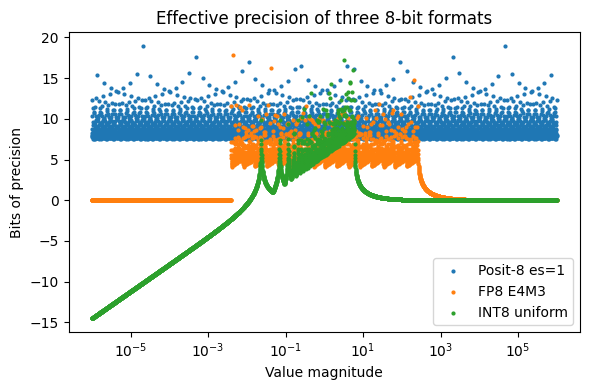

RMS bits of precision
Posit‑8 : 9.083989795842696
FP8 e4m3: 3.900813140622558
INT8   : 5.780549900486664


In [18]:

# Sample values log-uniformly
xs = np.logspace(-6, 6, num=4000)
q_posit = posit8_es1(xs)
q_fp8   = fp8_e4m3(xs)
q_int8  = int8_uniform(xs)

# Compute bits of precision
b_posit = bits_of_precision(xs, q_posit)
b_fp8   = bits_of_precision(xs, q_fp8)
b_int8  = bits_of_precision(xs, q_int8)

# Plot
plt.figure(figsize=(6,4))
plt.scatter(xs, b_posit, s=4, label='Posit‑8 es=1')
plt.scatter(xs, b_fp8,   s=4, label='FP8 E4M3')
plt.scatter(xs, b_int8,  s=4, label='INT8 uniform')
plt.xscale('log')
plt.xlabel('Value magnitude')
plt.ylabel('Bits of precision')
plt.title('Effective precision of three 8‑bit formats')
plt.legend()
plt.tight_layout()
plt.show()

# RMS precision scores
rms = lambda b: np.sqrt(np.mean(b**2))
print('RMS bits of precision')
print('Posit‑8 :', rms(b_posit))
print('FP8 e4m3:', rms(b_fp8))
print('INT8   :', rms(b_int8))
